# Regressors and exogenous data

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/exogenous_data.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>


This notebook serves as a tutorial for:

- Loading regressors to TSDataset
- Training and using a model with regressors

**Table of Contents**

* [What is regressor?](#chapter1)
    * [What is exogenous data?](#chapter1_1)
* [Dataset](#chapter2)
    * [Loading Dataset](#chapter2_1)
    * [EDA](#chapter2_2)
* [Forecast with regressors](#chapter3)


## 1. What is regressor? <a class="anchor" id="chapter1"></a>

In previous tutorials, we have shown how to work with **target time series**.

> Target time series is a time series we want to forecast.

But imagine that you have information about the future that can help model with forecasting target time series.
It may be information about holidays, weather, recurring events, marketing campaigns, etc.
We will call it **regressor**.

> Regressor is a time series that we are not interested in forecasting, however, it may help to forecast the target time series.

To apply an ML model that uses regressors to make more accurate forecasts,
we need to know how regressors affected the target time series in the past and information
about their values in the future.

### What is additional data? <a class="anchor" id="chapter1_1"></a>

In addition to this topic, there is also data that we don't know in advance,
but using it still allows us to make more accurate forecasts. This data we will call **additional data**.
For example, if many users bought a new phone few weeks ago we should expect more support requests on this product.

This means that in order to use additional data we should create regressors out of them.
For example, it could be done with LagTransform or TrendTransform.

In this tutorial we will not look at **additional data** and will focus on **regressors**.

## 2. Dataset <a class="anchor" id="chapter2"></a>
## 2.1 Loading Dataset <a class="anchor" id="chapter2_1"></a>

ETNA allows working with regressor as convenient as with target time series.

We are going to forecast the time series from [Tabular Playground Series - Jan 2022](https://www.kaggle.com/c/tabular-playground-series-jan-2022/overview).
The dataset contains daily merchandise sales – mugs, hats, and stickers – at two imaginary
store chains across three Scandinavian countries. As exogenous data, we will use
[Finland, Norway, and Sweden Weather Data 2015-2019](https://www.kaggle.com/adamwurdits/finland-norway-and-sweden-weather-data-20152019?select=nordics_weather.csv)
dataset containing daily country average precipitation, snow depth and air temperature data.

In [291]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

target_df = pd.read_csv("data/nordic_merch_sales.csv")
regressor_df = pd.read_csv("data/nordics_weather.csv")

The next step is converting the data into the ETNA format.
Code that allows us to do that is identical for target time series and regressors.

In [292]:
from etna.datasets import TSDataset

target_df = TSDataset.to_dataset(target_df)
target_df.tail()

segment,Finland_KaggleMart_Kaggle Hat,Finland_KaggleMart_Kaggle Mug,Finland_KaggleMart_Kaggle Sticker,Finland_KaggleRama_Kaggle Hat,Finland_KaggleRama_Kaggle Mug,Finland_KaggleRama_Kaggle Sticker,Norway_KaggleMart_Kaggle Hat,Norway_KaggleMart_Kaggle Mug,Norway_KaggleMart_Kaggle Sticker,Norway_KaggleRama_Kaggle Hat,Norway_KaggleRama_Kaggle Mug,Norway_KaggleRama_Kaggle Sticker,Sweden_KaggleMart_Kaggle Hat,Sweden_KaggleMart_Kaggle Mug,Sweden_KaggleMart_Kaggle Sticker,Sweden_KaggleRama_Kaggle Hat,Sweden_KaggleRama_Kaggle Mug,Sweden_KaggleRama_Kaggle Sticker
feature,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,
2018-12-27,573,414,177,1068,652,308,898,568,270,1604,1108,436,672,420,196,1127,745,319
2018-12-28,841,499,223,1398,895,431,1162,731,361,2178,1333,662,874,555,260,1540,990,441
2018-12-29,1107,774,296,1895,1398,559,1650,1113,518,2884,1816,874,1106,720,348,2169,1438,596
2018-12-30,1113,757,326,1878,1241,554,1809,1052,500,2851,1935,833,1133,730,336,2138,1303,587
2018-12-31,822,469,238,1231,831,360,1124,728,351,2128,1383,561,823,570,250,1441,1004,388


As you can see, the target ends in 2018, and regressors end in 2019,
so we have prior information a year ahead.

In [293]:
regressor_df = TSDataset.to_dataset(regressor_df)
regressor_df.tail()

segment    Finland_KaggleMart_Kaggle Hat                                  \
feature                    precipitation  snow_depth      tavg      tmax   
timestamp                                                                  
2019-12-27                      0.028249  109.550000 -8.529630 -3.161039   
2019-12-28                      0.789266  116.421053 -9.107407 -4.703947   
2019-12-29                      4.976966  117.117647 -0.418519  1.264052   
2019-12-30                      1.229775  160.500000  2.292593  3.344156   
2019-12-31                      0.225281  124.647059 -2.859259  1.580519   

segment               Finland_KaggleMart_Kaggle Mug                        \
feature          tmin                 precipitation  snow_depth      tavg   
timestamp                                                                   
2019-12-27 -10.895425                      0.028249  109.550000 -8.529630   
2019-12-28 -15.288889                      0.789266  116.421053 -9.107407   
2019-12-29  -7.722078                      4.976966  117.117647 -0.418519   
2019-12-30  -0.202632                      1.229775  160.500000  2.292593   
2019-12-31  -6.921569                      0.225281  124.647059 -2.859259   

segment                          ... Sweden_KaggleRama_Kaggle Mug              \
feature         tmax       tmin  ...                precipitation  snow_depth   
timestamp                        ...                                            
2019-12-27 -3.161039 -10.895425  ...                     0.105079  141.220930   
2019-12-28 -4.703947 -15.288889  ...                     1.117688  142.955224   
2019-12-29  1.264052  -7.722078  ...                     1.758669  136.725146   
2019-12-30  3.344156  -0.202632  ...                     0.561996  120.740741   
2019-12-31  1.580519  -6.921569  ...                     0.848161  131.583333   

segment                                   Sweden_KaggleRama_Kaggle Sticker  \
feature         tavg      tmax       tmin                    precipitation   
timestamp                                                                    
2019-12-27 -4.277778 -2.391204  -8.993458                         0.105079   
2019-12-28 -3.866667 -3.006542 -11.593056                         1.117688   
2019-12-29  1.755556  3.692056  -4.516204                         1.758669   
2019-12-30  4.900000  6.135648   1.859070                         0.561996   
2019-12-31  1.722222  4.376606  -2.290278                         0.848161   

segment                                                
feature     snow_depth      tavg      tmax       tmin  
timestamp                                              
2019-12-27  141.220930 -4.277778 -2.391204  -8.993458  
2019-12-28  142.955224 -3.866667 -3.006542 -11.593056  
2019-12-29  136.725146  1.755556  3.692056  -4.516204  
2019-12-30  120.740741  4.900000  6.135648   1.859070  
2019-12-31  131.583333  1.722222  4.376606  -2.290278  

[5 rows x 90 columns]

Then we have to create TSDataset with both target time series and regressors.
TSDataset expects us to put target time series in `df` argument and regressors in `df_exog`.
We should do it because regressors contain information about the target's future.
TSDataset ensures we don't mix them.

`known_future` is a parameter that allows to specify what columns contain prior future information.
This allows TSDataset to determine which columns are **regressors** and which columns are **additional data**.

In [294]:
ts = TSDataset(df=target_df, freq="D", df_exog=regressor_df, known_future="all")
ts.head()

segment    Finland_KaggleMart_Kaggle Hat                                \
feature                    precipitation  snow_depth target       tavg   
timestamp                                                                
2015-01-01                      1.714141  284.545455  520.0   1.428571   
2015-01-02                     10.016667  195.000000  493.0   0.553571   
2015-01-03                      3.956061  284.294118  535.0  -1.739286   
2015-01-04                      0.246193  260.772727  544.0  -7.035714   
2015-01-05                      0.036364  236.900000  378.0 -17.164286   

segment                         Finland_KaggleMart_Kaggle Mug              \
feature         tmax       tmin                 precipitation  snow_depth   
timestamp                                                                   
2015-01-01  2.912739  -1.015287                      1.714141  284.545455   
2015-01-02  2.358599  -0.998718                     10.016667  195.000000   
2015-01-03  0.820382  -3.463871                      3.956061  284.294118   
2015-01-04 -3.110828  -9.502581                      0.246193  260.772727   
2015-01-05 -8.727564 -19.004487                      0.036364  236.900000   

segment                       ... Sweden_KaggleRama_Kaggle Mug        \
feature    target       tavg  ...                       target  tavg   
timestamp                     ...                                      
2015-01-01  329.0   1.428571  ...                        706.0  3.47   
2015-01-02  318.0   0.553571  ...                        653.0  3.80   
2015-01-03  360.0  -1.739286  ...                        734.0  1.61   
2015-01-04  332.0  -7.035714  ...                        657.0 -1.35   
2015-01-05  243.0 -17.164286  ...                        512.0 -4.27   

segment                        Sweden_KaggleRama_Kaggle Sticker             \
feature         tmax      tmin                    precipitation snow_depth   
timestamp                                                                    
2015-01-01  5.415354  0.221569                         3.642278  84.924623   
2015-01-02  5.097244  0.294882                         2.414665  67.043702   
2015-01-03  2.140392 -1.776680                         0.212793  79.945946   
2015-01-04 -0.648425 -5.173123                         0.226833  78.997290   
2015-01-05 -3.027451 -9.544488                         0.515601  79.736148   

segment                                      
feature    target  tavg      tmax      tmin  
timestamp                                    
2015-01-01  324.0  3.47  5.415354  0.221569  
2015-01-02  293.0  3.80  5.097244  0.294882  
2015-01-03  319.0  1.61  2.140392 -1.776680  
2015-01-04  300.0 -1.35 -0.648425 -5.173123  
2015-01-05  227.0 -4.27 -3.027451 -9.544488  

[5 rows x 108 columns]

### 2.2 EDA <a class="anchor" id="chapter2_2"></a>

TSDataset joins regressors and the target time series,
so we can visualize and analyze regressors in the same fashion as target time series.
More information in [EDA notebook](https://github.com/tinkoff-ai/etna/blob/09a7938103c56e10bcdac7f13def9fa66c2c88dd/examples/EDA.ipynb).

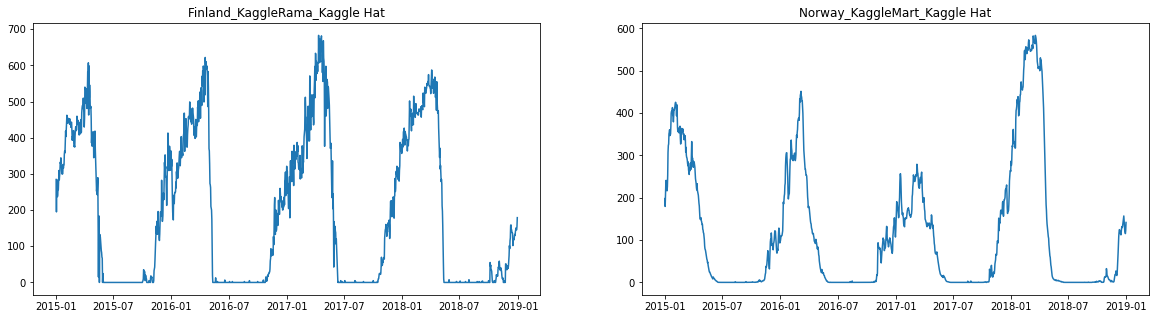

In [295]:
ts.plot(column="snow_depth", n_segments=2)

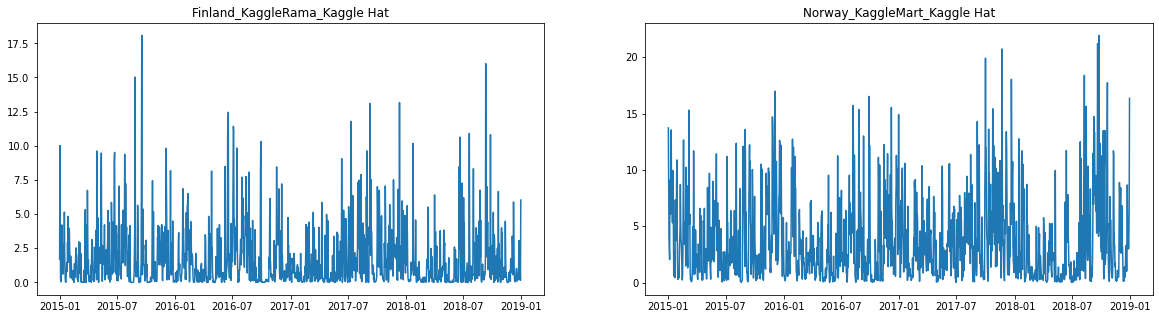

In [296]:
ts.plot(column="precipitation", n_segments=2)

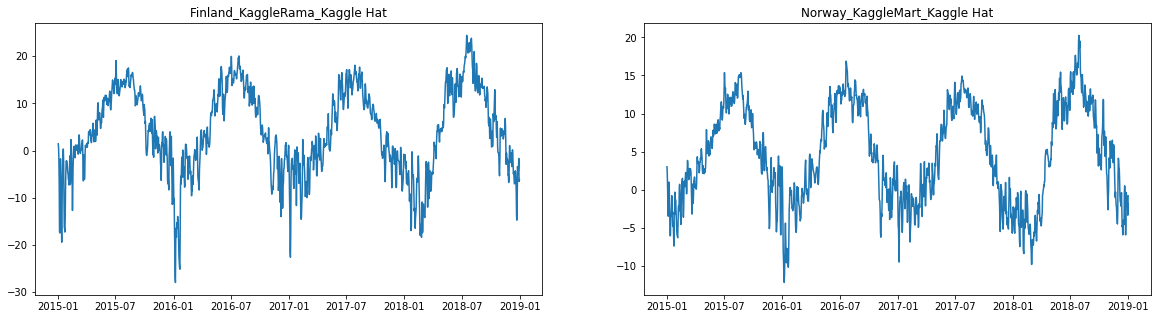

In [297]:
ts.plot(column="tavg", n_segments=2)

## 3. Forecast with regressors <a class="anchor" id="chapter3"></a>

We will use LinearPerSegmentModel. It is a simple model that works with regressors.

> Note: some models do not work with regressors. In this case, they will warn you about it.

We should forecast merchandise sales a year ahead using regressors with information about weather.

In [298]:
from etna.models import LinearPerSegmentModel

HORIZON = 365
model = LinearPerSegmentModel()

ETNA allows to configure the transforms to work with regressors the same way as they work with the time series.

In [299]:
from etna.transforms import FilterFeaturesTransform

from etna.transforms import MeanTransform # math
from etna.transforms import DateFlagsTransform, HolidayTransform # datetime
from etna.transforms import LagTransform # lags

transforms = [
              LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+28)), out_column="target_lag"),
              LagTransform(in_column="tavg", lags=list(range(1, 3)), out_column="tavg_lag"),
              MeanTransform(in_column="tavg", window=7, out_column="tavg_mean"),
              MeanTransform(in_column="target_lag_365", out_column="target_mean", window=104, seasonality=7),
              DateFlagsTransform(day_number_in_week=True,
                                 day_number_in_month=True,
                                 is_weekend=True,
                                 special_days_in_week=[4],
                                 out_column="date_flag"),
              HolidayTransform(iso_code="SWE", out_column="SWE_holidays"),
              HolidayTransform(iso_code="NOR", out_column="NOR_holidays"),
              HolidayTransform(iso_code="FIN", out_column="FIN_holidays"),
              LagTransform(in_column="SWE_holidays", lags=list(range(2,6)), out_column="SWE_holidays_lag"),
              LagTransform(in_column="NOR_holidays", lags=list(range(2,6)), out_column="NOR_holidays_lag"),
              LagTransform(in_column="FIN_holidays", lags=list(range(2,6)), out_column="FIN_holidays_lag"),
              FilterFeaturesTransform(exclude=["precipitation", "snow_depth", "tmin", "tmax"]),
]

Next steps are literally identical to the situation when we work with target time series only.

In [300]:
from etna.pipeline import Pipeline
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

In [301]:
from etna.metrics import SMAPE

metrics, forecasts, _ = pipeline.backtest(ts, metrics=[SMAPE()], aggregate_metrics=True, n_folds=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.0s finished


In [302]:
metrics

,segment,SMAPE
0,Finland_KaggleMart_Kaggle Hat,6.794678
1,Finland_KaggleMart_Kaggle Mug,7.882563
2,Finland_KaggleMart_Kaggle Sticker,7.580532
3,Finland_KaggleRama_Kaggle Hat,6.678928
4,Finland_KaggleRama_Kaggle Mug,7.508890
5,Finland_KaggleRama_Kaggle Sticker,7.543868
6,Norway_KaggleMart_Kaggle Hat,9.280566
7,Norway_KaggleMart_Kaggle Mug,11.891015
8,Norway_KaggleMart_Kaggle Sticker,11.443262
9,Norway_KaggleRama_Kaggle Hat,9.059234


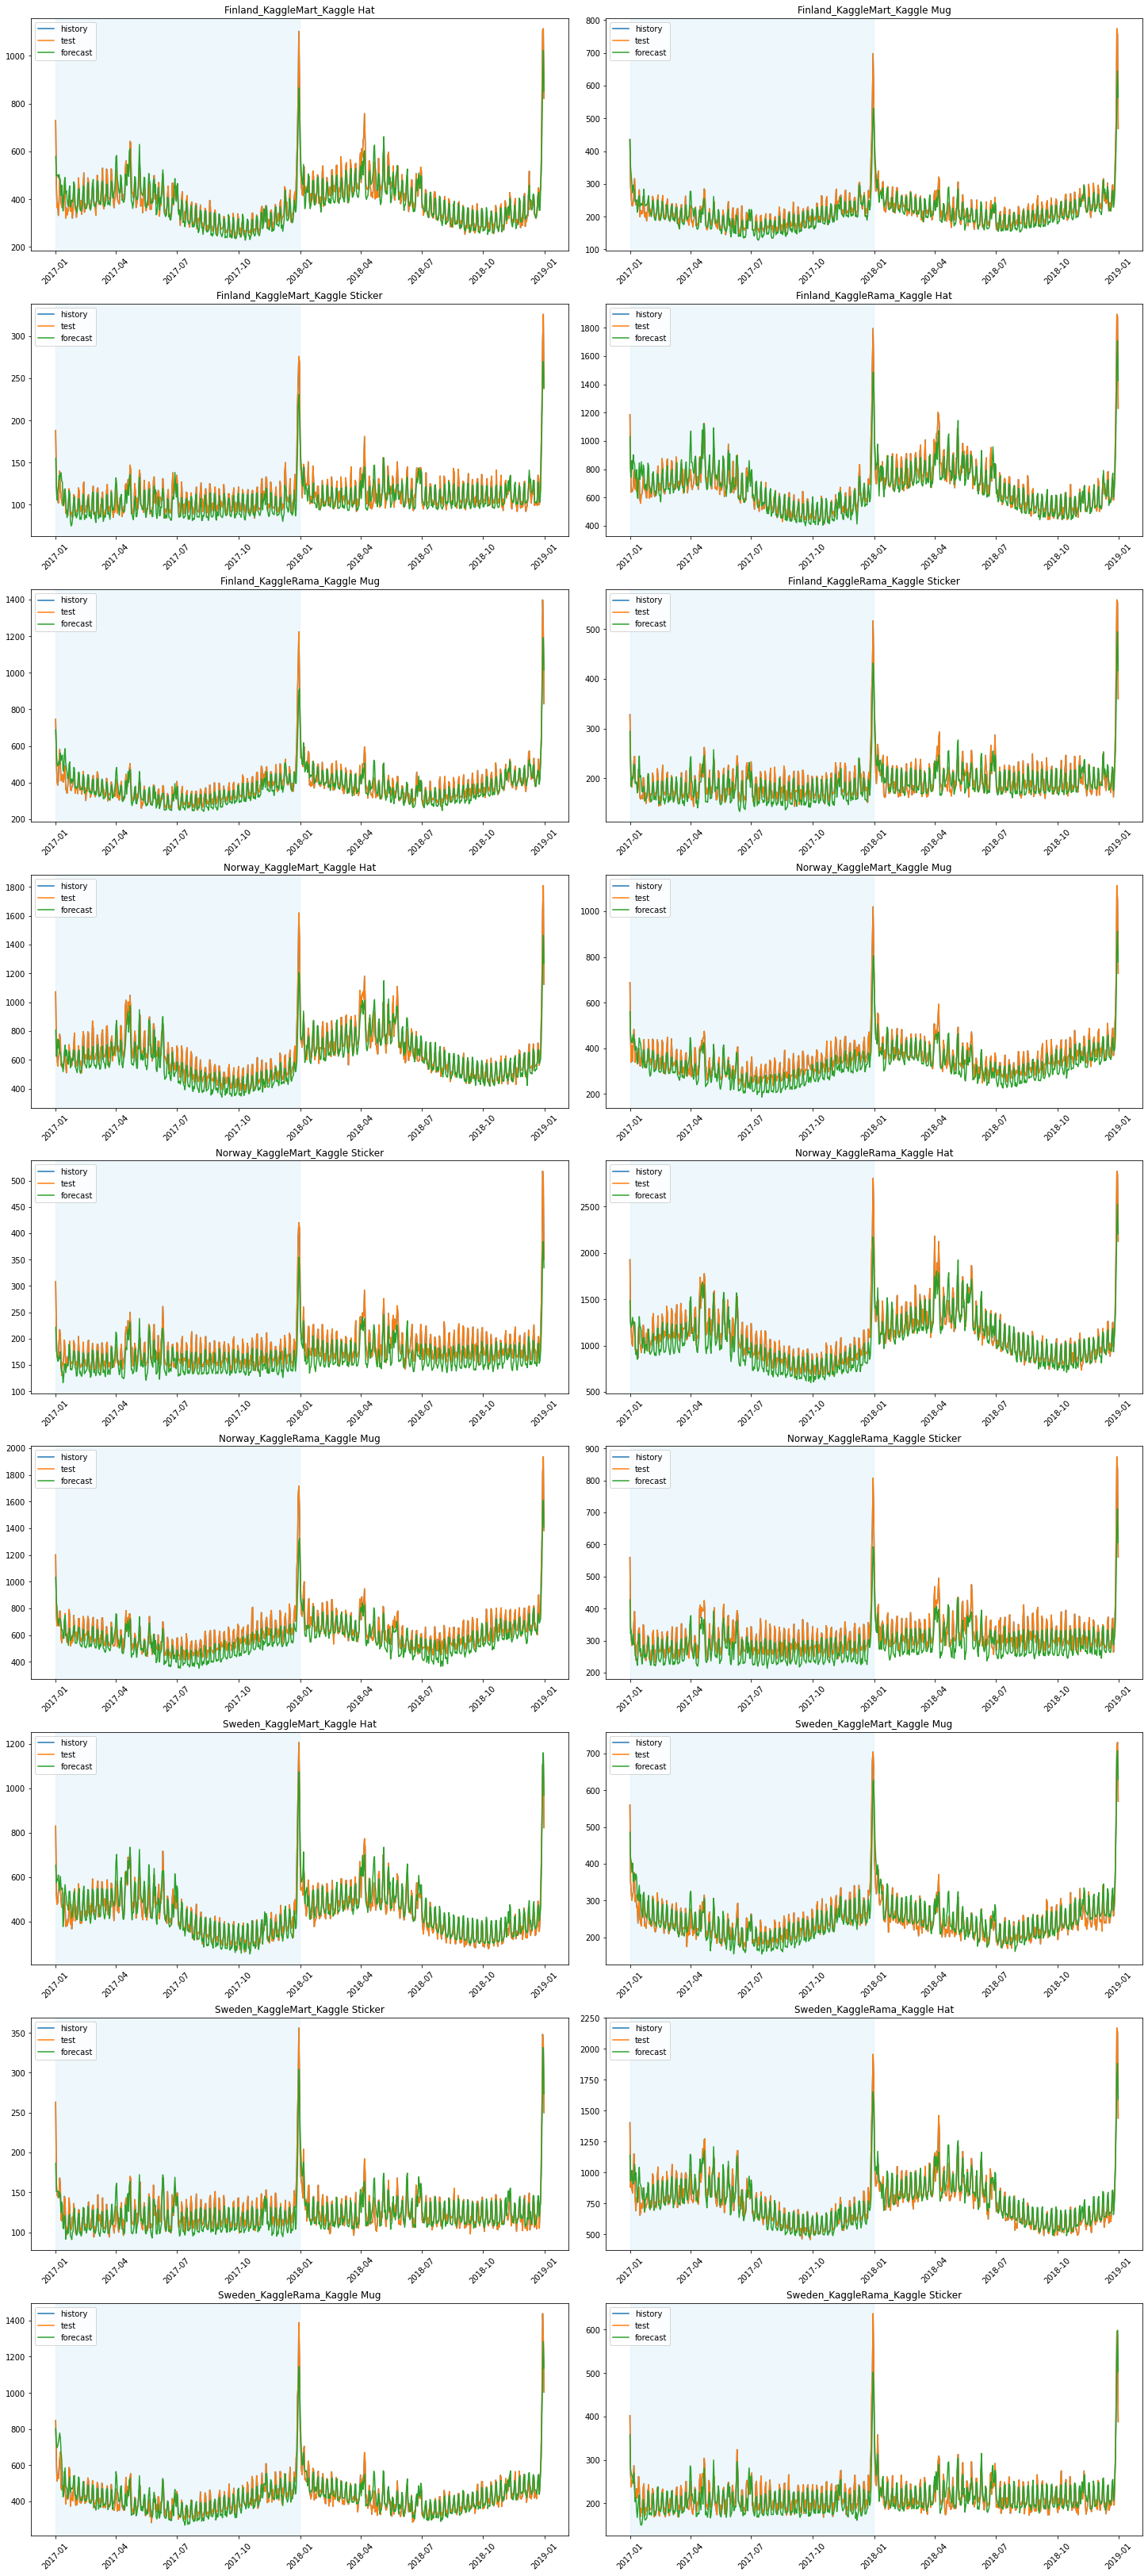

In [303]:
from etna.analysis import plot_backtest

plot_backtest(forecasts, ts)


Supporting more general types of conditioning and strategies for regressors is a future feature on the ETNA development roadmap.

Stay safe!
